<a href="https://www.kaggle.com/code/handandegerli/rating-product-n-sorting-reviews-in-amazon?scriptVersionId=180925028" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Rating Product & Sorting Reviews in Amazon

---

**Business Problem:** One of the most important problems in e-commerce is the correct calculation of the points given to the products after the sale. The solution to this problem means providing greater customer satisfaction for the e-commerce site, product prominence for sellers and a seamless shopping experience for buyers. Another problem is the correct listing of the comments given to the products. Since misleading comments will directly affect the sale of the product, it will cause both financial and customer loss. In solving these 2 basic problems, e-commerce site and sellers will increase their sales, while customers will complete their purchasing journey without any problems.

---

**Import Libraries**

In [1]:
import math
import scipy.stats as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
df_ = pd.read_csv('/kaggle/input/amazon-review-dataset/amazon_review.csv')

In [3]:
df = df_.copy()

### Explotary Data Analysis (EDA)
---

In [4]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0000,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0000,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0000,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0000,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0000,best deal around,1373673600,2013-07-13,513,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      4915 non-null   object 
 1   asin            4915 non-null   object 
 2   reviewerName    4914 non-null   object 
 3   helpful         4915 non-null   object 
 4   reviewText      4914 non-null   object 
 5   overall         4915 non-null   float64
 6   summary         4915 non-null   object 
 7   unixReviewTime  4915 non-null   int64  
 8   reviewTime      4915 non-null   object 
 9   day_diff        4915 non-null   int64  
 10  helpful_yes     4915 non-null   int64  
 11  total_vote      4915 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 460.9+ KB


In [6]:
df.shape

(4915, 12)

In [7]:
df.nunique()

reviewerID        4915
asin                 1
reviewerName      4594
helpful             42
reviewText        4912
overall              5
summary           3885
unixReviewTime     690
reviewTime         690
day_diff           690
helpful_yes         23
total_vote          26
dtype: int64

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
overall,4915.0000,4.5876,0.9968,1.0000,5.0000,5.0000,5.0000,5.0000
unixReviewTime,4915.0000,1379465001.6684,15818574.3228,1339200000.0000,1365897600.0000,1381276800.0000,1392163200.0000,1406073600.0000
day_diff,4915.0000,437.3670,209.4399,1.0000,281.0000,431.0000,601.0000,1064.0000
helpful_yes,4915.0000,1.3111,41.6192,0.0000,0.0000,0.0000,0.0000,1952.0000
total_vote,4915.0000,1.5215,44.1231,0.0000,0.0000,0.0000,0.0000,2020.0000


**Check rating frequncy**

         overall   Ratio
overall                 
5.0000      3922 79.8000
4.0000       527 10.7200
1.0000       244  4.9600
3.0000       142  2.8900
2.0000        80  1.6300


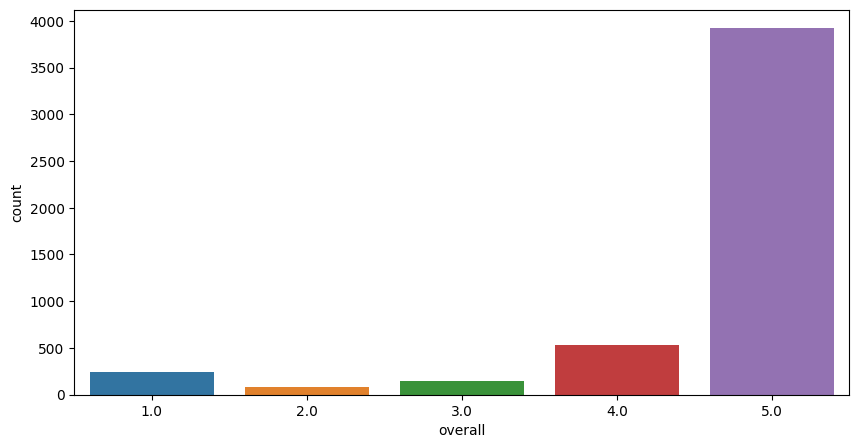

In [9]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       'Ratio': round(100*(dataframe[col_name].value_counts()) / len(dataframe), 2)}))
    
    if plot:
        sns.countplot(x=col_name, data=dataframe)
        plt.show()
        
   

plt.figure(figsize=(10, 5))
cat_summary(df, 'overall', plot=True)

**Max and min date**

In [10]:
df['reviewTime'].agg({'min', 'max'})

max    2014-12-07
min    2012-01-09
Name: reviewTime, dtype: object

### Task 1: Rating the product

**Step 1: Average rating (overall)**

In [11]:
df["overall"].mean()

4.587589013224822

**Step 2: Time-based weighted average**

**Convert reviewtime to datetime object**

In [12]:
df["reviewTime"] = pd.to_datetime(df["reviewTime"])

In [13]:
df.dtypes

reviewerID                object
asin                      object
reviewerName              object
helpful                   object
reviewText                object
overall                  float64
summary                   object
unixReviewTime             int64
reviewTime        datetime64[ns]
day_diff                   int64
helpful_yes                int64
total_vote                 int64
dtype: object

**Calculate current date**

In [14]:
current_date = df["reviewTime"].max()
current_date

Timestamp('2014-12-07 00:00:00')

**Create 'days' column**

In [15]:
df["days"] = (current_date - df["reviewTime"]).dt.days

In [16]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0000,Four Stars,1406073600,2014-07-23,138,0,0,137
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0000,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,408
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0000,nothing to really say....,1356220800,2012-12-23,715,0,0,714
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0000,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,381
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0000,best deal around,1373673600,2013-07-13,513,0,0,512


**Calculate the quantiles**

In [17]:
quantiles = df['days'].quantile(q=[0.05, 0.25, 0.7])
quantiles

0.0500    97.0000
0.2500   280.0000
0.7000   561.8000
Name: days, dtype: float64

In [18]:
q1 = quantiles.iloc[0]
q2 = quantiles.iloc[1]
q3 = quantiles.iloc[2]

**Less than q1 (97 days)**

In [19]:
df[df["days"] <= q1]["overall"].agg(["mean", "count"])

mean      4.7490
count   263.0000
Name: overall, dtype: float64

**More than q1 and Less than q2**

In [20]:
df[(df["days"] > q1) & (df["days"] <= q2)]["overall"].agg(["mean", "count"])

mean      4.6814
count   973.0000
Name: overall, dtype: float64

**Between q2 and q3**

In [21]:
df[(df["days"] > q2) & (df["days"] <= q3)]["overall"].agg(["mean", "count"])

mean       4.6093
count   2204.0000
Name: overall, dtype: float64

**More than q3**

In [22]:
df[df["days"] > q3]["overall"].agg(["mean", "count"])

mean       4.4644
count   1475.0000
Name: overall, dtype: float64

**Calculate the time-based weighted average**

In [23]:
def time_based_weighted_average(dataframe, w1=28, w2=26, w3=24, w4=22):
    rating = dataframe[dataframe["days"] <= q1]["overall"].mean() * w1 + \
    dataframe[(dataframe["days"] > q1) & (dataframe["days"] <= q2)]["overall"].mean() * w2 + \
    dataframe[(dataframe["days"] > q2) & (dataframe["days"] <= q3)]["overall"].mean() * w3 + \
    dataframe[(dataframe["days"] > q3)]["overall"].mean() * w4
    
    return rating/100

In [24]:
time_based_weighted_average(df)

4.635309938149424

### Task 2: Sorting top 20 reviews

**Step 1: Create a 'helpful_no' variables**

In [25]:
df["helpful_no"] = df["total_vote"] - df["helpful_yes"]

In [26]:
df['helpful_no'].value_counts()

helpful_no
0      4674
1       175
2        43
3         7
27        2
4         2
6         2
73        1
8         1
10        1
68        1
110       1
183       1
77        1
126       1
14        1
9         1
Name: count, dtype: int64

**Step 2: Calculate the score_pos_neg_diff, score_average_rating, wilson_lower_bound**

**Define a function called score_pos_neg_diff that calculate the difference between positive and negative reviews**

In [27]:
def score_pos_neg_diff(pos, neg):
    return pos - neg

In [28]:
df["score_pos_neg_diff"] = df.apply(lambda x: score_pos_neg_diff(x["helpful_yes"], x["helpful_no"]), axis=1)

In [29]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days,helpful_no,score_pos_neg_diff
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0000,Four Stars,1406073600,2014-07-23,138,0,0,137,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0000,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,408,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0000,nothing to really say....,1356220800,2012-12-23,715,0,0,714,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0000,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,381,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0000,best deal around,1373673600,2013-07-13,513,0,0,512,0,0


**Define a function called score_average_rating that calculate the positive percentage reviews**

In [30]:
def score_average_rating(up, down):
    if (up + down) == 0:
        return 0
    return up / (up + down)

In [31]:
df["score_average_rating"] = df.apply(lambda x: score_average_rating(x["helpful_yes"], x["helpful_no"]), axis=1)

In [32]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days,helpful_no,score_pos_neg_diff,score_average_rating
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0000,Four Stars,1406073600,2014-07-23,138,0,0,137,0,0,0.0000
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0000,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,408,0,0,0.0000
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0000,nothing to really say....,1356220800,2012-12-23,715,0,0,714,0,0,0.0000
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0000,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,381,0,0,0.0000
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0000,best deal around,1373673600,2013-07-13,513,0,0,512,0,0,0.0000


**Wilson lower bound function**

In [33]:
def wilson_lower_bound(up, down, confidence=0.95):
    
    n = up + down
    if n == 0:
        return 0
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    phat = 1.0 * up / n
    score = (phat + z * z / (2 * n) - z * math.sqrt((phat * (1 - phat) + z * z / (4 * n)) / n)) / (1 + z * z / n)
    
    return score

In [34]:
df["wilson_lower_bound"] = df.apply(lambda x: wilson_lower_bound(x["helpful_yes"], x["helpful_no"]), axis=1)

In [35]:
df.tail()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days,helpful_no,score_pos_neg_diff,score_average_rating,wilson_lower_bound
4910,A2LBMKXRM5H2W9,B007WTAJTO,"ZM ""J""","[0, 0]",I bought this Sandisk 16GB Class 10 to use wit...,1.0000,Do not waste your money.,1374537600,2013-07-23,503,0,0,502,0,0,0.0000,0.0000
4911,ALGDLRUI1ZPCS,B007WTAJTO,Zo,"[0, 0]",Used this for extending the capabilities of my...,5.0000,Great item!,1377129600,2013-08-22,473,0,0,472,0,0,0.0000,0.0000
4912,A2MR1NI0ENW2AD,B007WTAJTO,Z S Liske,"[0, 0]",Great card that is very fast and reliable. It ...,5.0000,Fast and reliable memory card,1396224000,2014-03-31,252,0,0,251,0,0,0.0000,0.0000
4913,A37E6P3DSO9QJD,B007WTAJTO,Z Taylor,"[0, 0]",Good amount of space for the stuff I want to d...,5.0000,Great little card,1379289600,2013-09-16,448,0,0,447,0,0,0.0000,0.0000
4914,A8KGFTFQ86IBR,B007WTAJTO,Zza,"[0, 0]",I've heard bad things about this 64gb Micro SD...,5.0000,So far so good.,1388620800,2014-02-01,310,0,0,309,0,0,0.0000,0.0000


**Step 3: Sort dataframe**

In [36]:
df.sort_values("wilson_lower_bound", ascending=False).head(20)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days,helpful_no,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,A12B7ZMXFI6IXY,B007WTAJTO,"Hyoun Kim ""Faluzure""","[1952, 2020]",[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,5.0000,UPDATED - Great w/ Galaxy S4 & Galaxy Tab 4 10...,1367366400,2013-01-05,702,1952,2020,701,68,1884,0.9663,0.9575
3449,AOEAD7DPLZE53,B007WTAJTO,NLee the Engineer,"[1428, 1505]",I have tested dozens of SDHC and micro-SDHC ca...,5.0000,Top of the class among all (budget-priced) mic...,1348617600,2012-09-26,803,1428,1505,802,77,1351,0.9488,0.9365
4212,AVBMZZAFEKO58,B007WTAJTO,SkincareCEO,"[1568, 1694]",NOTE: please read the last update (scroll to ...,1.0000,1 Star reviews - Micro SDXC card unmounts itse...,1375660800,2013-05-08,579,1568,1694,578,126,1442,0.9256,0.9121
317,A1ZQAQFYSXL5MQ,B007WTAJTO,"Amazon Customer ""Kelly""","[422, 495]","If your card gets hot enough to be painful, it...",1.0000,"Warning, read this!",1346544000,2012-02-09,1033,422,495,1032,73,349,0.8525,0.8186
4672,A2DKQQIZ793AV5,B007WTAJTO,Twister,"[45, 49]",Sandisk announcement of the first 128GB micro ...,5.0000,Super high capacity!!! Excellent price (on Am...,1394150400,2014-07-03,158,45,49,157,4,41,0.9184,0.8081
1835,A1J6VSUM80UAF8,B007WTAJTO,goconfigure,"[60, 68]",Bought from BestBuy online the day it was anno...,5.0000,I own it,1393545600,2014-02-28,283,60,68,282,8,52,0.8824,0.7847
3981,A1K91XXQ6ZEBQR,B007WTAJTO,"R. Sutton, Jr. ""RWSynergy""","[112, 139]",The last few days I have been diligently shopp...,5.0000,"Resolving confusion between ""Mobile Ultra"" and...",1350864000,2012-10-22,777,112,139,776,27,85,0.8058,0.7321
3807,AFGRMORWY2QNX,B007WTAJTO,R. Heisler,"[22, 25]",I bought this card to replace a lost 16 gig in...,3.0000,"Good buy for the money but wait, I had an issue!",1361923200,2013-02-27,649,22,25,648,3,19,0.8800,0.7004
4306,AOHXKM5URSKAB,B007WTAJTO,Stellar Eller,"[51, 65]","While I got this card as a ""deal of the day"" o...",5.0000,Awesome Card!,1339200000,2012-09-06,823,51,65,822,14,37,0.7846,0.6703
4596,A1WTQUOQ4WG9AI,B007WTAJTO,"Tom Henriksen ""Doggy Diner""","[82, 109]",Hi:I ordered two card and they arrived the nex...,1.0000,Designed incompatibility/Don't support SanDisk,1348272000,2012-09-22,807,82,109,806,27,55,0.7523,0.6636


In [37]:
df.sort_values("score_pos_neg_diff", ascending=False).head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days,helpful_no,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,A12B7ZMXFI6IXY,B007WTAJTO,"Hyoun Kim ""Faluzure""","[1952, 2020]",[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,5.0000,UPDATED - Great w/ Galaxy S4 & Galaxy Tab 4 10...,1367366400,2013-01-05,702,1952,2020,701,68,1884,0.9663,0.9575
4212,AVBMZZAFEKO58,B007WTAJTO,SkincareCEO,"[1568, 1694]",NOTE: please read the last update (scroll to ...,1.0000,1 Star reviews - Micro SDXC card unmounts itse...,1375660800,2013-05-08,579,1568,1694,578,126,1442,0.9256,0.9121
3449,AOEAD7DPLZE53,B007WTAJTO,NLee the Engineer,"[1428, 1505]",I have tested dozens of SDHC and micro-SDHC ca...,5.0000,Top of the class among all (budget-priced) mic...,1348617600,2012-09-26,803,1428,1505,802,77,1351,0.9488,0.9365
317,A1ZQAQFYSXL5MQ,B007WTAJTO,"Amazon Customer ""Kelly""","[422, 495]","If your card gets hot enough to be painful, it...",1.0000,"Warning, read this!",1346544000,2012-02-09,1033,422,495,1032,73,349,0.8525,0.8186
3981,A1K91XXQ6ZEBQR,B007WTAJTO,"R. Sutton, Jr. ""RWSynergy""","[112, 139]",The last few days I have been diligently shopp...,5.0000,"Resolving confusion between ""Mobile Ultra"" and...",1350864000,2012-10-22,777,112,139,776,27,85,0.8058,0.7321
4596,A1WTQUOQ4WG9AI,B007WTAJTO,"Tom Henriksen ""Doggy Diner""","[82, 109]",Hi:I ordered two card and they arrived the nex...,1.0000,Designed incompatibility/Don't support SanDisk,1348272000,2012-09-22,807,82,109,806,27,55,0.7523,0.6636
1835,A1J6VSUM80UAF8,B007WTAJTO,goconfigure,"[60, 68]",Bought from BestBuy online the day it was anno...,5.0000,I own it,1393545600,2014-02-28,283,60,68,282,8,52,0.8824,0.7847
4672,A2DKQQIZ793AV5,B007WTAJTO,Twister,"[45, 49]",Sandisk announcement of the first 128GB micro ...,5.0000,Super high capacity!!! Excellent price (on Am...,1394150400,2014-07-03,158,45,49,157,4,41,0.9184,0.8081
4306,AOHXKM5URSKAB,B007WTAJTO,Stellar Eller,"[51, 65]","While I got this card as a ""deal of the day"" o...",5.0000,Awesome Card!,1339200000,2012-09-06,823,51,65,822,14,37,0.7846,0.6703
315,A2J26NNQX6WKAU,B007WTAJTO,"Amazon Customer ""johncrea""","[38, 48]",Bought this card to use with my Samsung Galaxy...,5.0000,Samsung Galaxy Tab2 works with this card if re...,1344816000,2012-08-13,847,38,48,846,10,28,0.7917,0.6574


In [38]:
df.sort_values("score_average_rating", ascending=False).head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,days,helpful_no,score_pos_neg_diff,score_average_rating,wilson_lower_bound
4277,A35KXSU6AD1481,B007WTAJTO,S. Q.,"[1, 1]",I have a galaxy note II and after rooting I no...,5.0000,Perfect!!,1355875200,2012-12-19,719,1,1,718,0,1,1.0000,0.2065
2881,A3VSG5X7GPNNW6,B007WTAJTO,Lou Thomas,"[1, 1]",The Nexus One is listed as supporting a maximu...,5.0000,Nexus One Loves This Card!,1349049600,2012-01-10,1063,1,1,1062,0,1,1.0000,0.2065
1073,A2ZXEKQ2OBZLEE,B007WTAJTO,C. Sanchez,"[1, 1]",I used it with my Samsung S4 and it works grea...,5.0000,Tons of space for phone,1376352000,2013-08-13,482,1,1,481,0,1,1.0000,0.2065
445,AIWBDRNBODLEA,B007WTAJTO,"Apache ""Elizabeth""","[1, 1]",This is exactly what I was looking for to upgr...,4.0000,Amazon Great Prices,1387324800,2013-12-18,355,1,1,354,0,1,1.0000,0.2065
3923,A2PH4RGYVR34L,B007WTAJTO,Rock Your Roots,"[1, 1]","It's a SanDisk, so what more is there to say? ...",5.0000,What more to say?,1388361600,2013-12-30,343,1,1,342,0,1,1.0000,0.2065
435,AUH8I22ITG020,B007WTAJTO,Anthony L cate,"[1, 1]",This is working great in my AT&T Galaxy Note. ...,5.0000,Love the extra storage,1343088000,2012-07-24,867,1,1,866,0,1,1.0000,0.2065
2901,A28TRYU3FJ039C,B007WTAJTO,luis,"[1, 1]",Not a good typer or speller :) here is what I ...,5.0000,Awesome and fast card :),1368403200,2013-05-13,574,1,1,573,0,1,1.0000,0.2065
2204,AANX2UN8NPE22,B007WTAJTO,"jbwam ""jbwam""","[1, 1]",I just called Sandisk and they say they have a...,2.0000,Sandisk will replace failures due to bad batch...,1371168000,2013-06-14,542,1,1,541,0,1,1.0000,0.2065
2206,A3KO3964CNP0XN,B007WTAJTO,JCBiker,"[1, 1]",I bought this for my garmin virb action cam. ...,5.0000,Great card,1383177600,2013-10-31,403,1,1,402,0,1,1.0000,0.2065
3408,A20WUUD9EDWY4N,B007WTAJTO,"Neng Vang ""Neng2012""","[1, 1]",Very good card and still working now in my car...,5.0000,working no problem,1374710400,2013-07-25,501,1,1,500,0,1,1.0000,0.2065
